## Library

In [1]:
import math
import numpy as np
import pandas as pd

import cv2
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [2]:
df = pd.read_csv('DATA/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [4]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [5]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [6]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

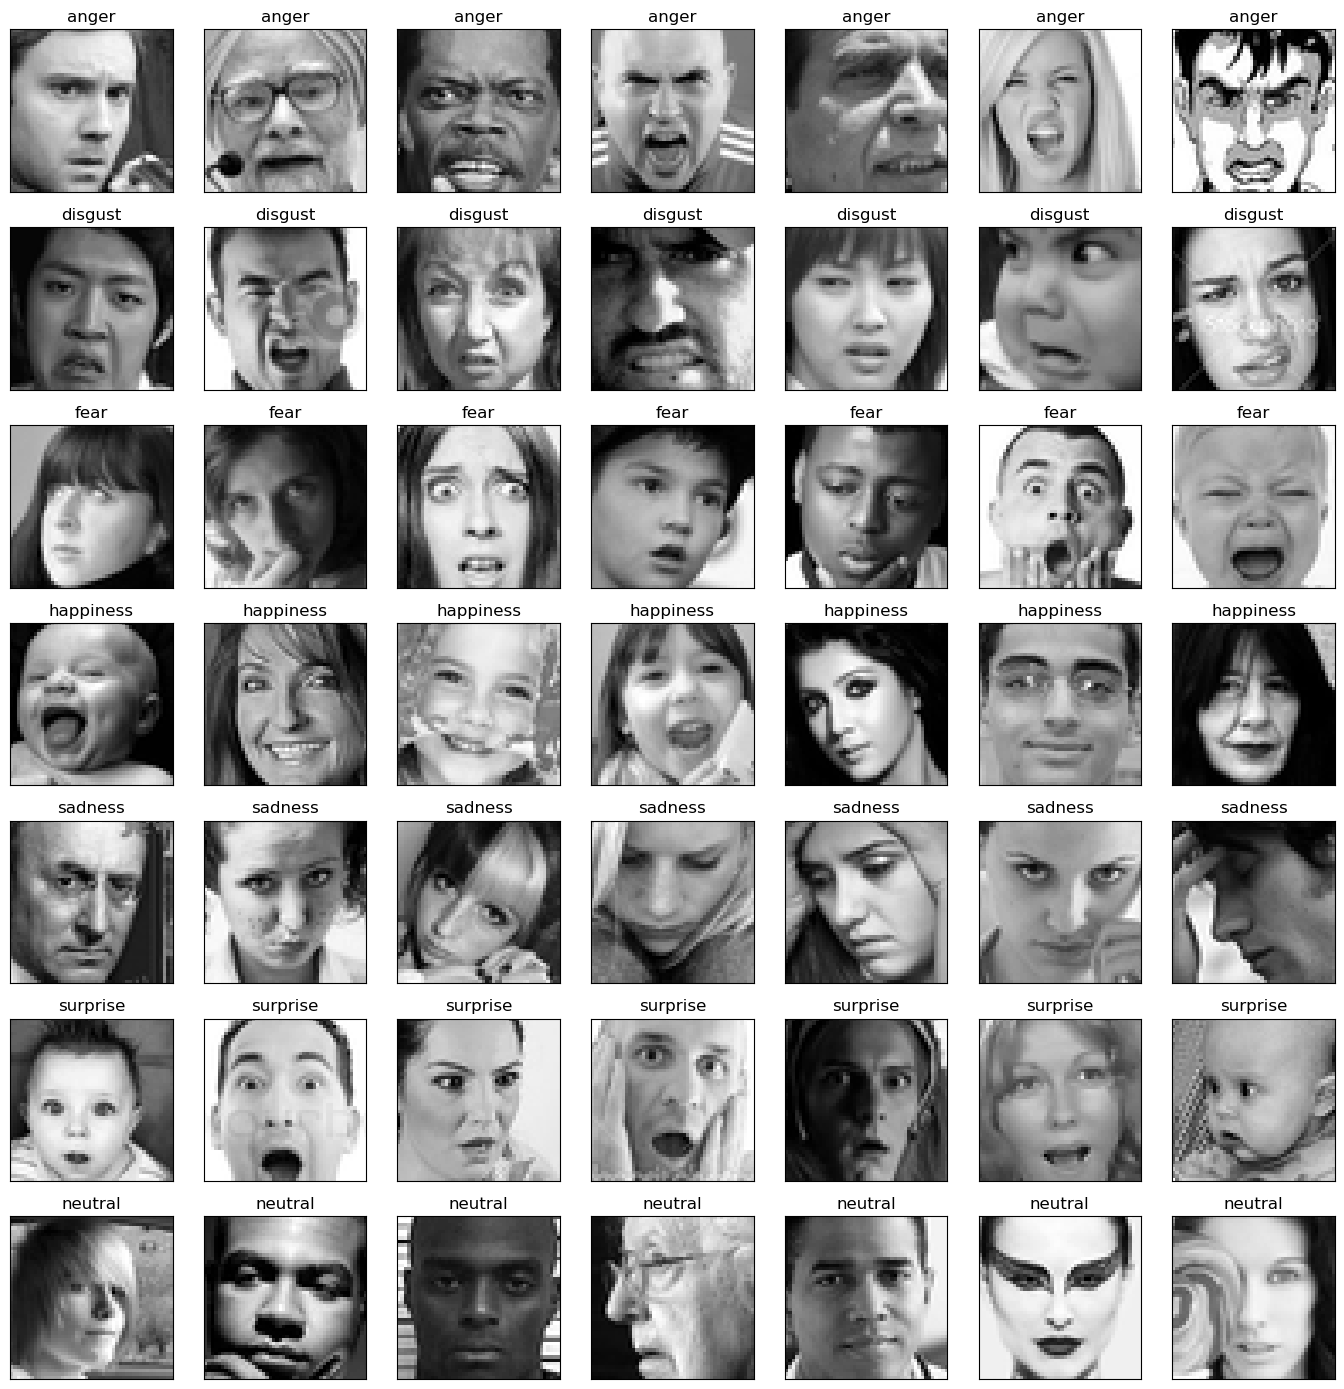

In [7]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

### Now I will make the data compatible for neural networks.

In [8]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [9]:
img_array.shape

(35887, 48, 48)

In [10]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


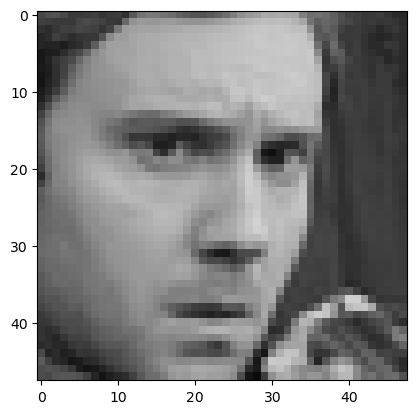

In [11]:
pyplot.imshow(img_features[0].astype(np.uint8));

In [12]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [13]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


### Splitting the data into training and validation set.

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(img_features, 
                                                      img_labels, 
                                                      shuffle = True, 
                                                      stratify = img_labels, 
                                                      test_size = 0.1, 
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [15]:
del df
del img_features
del img_labels

In [16]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

### Normalizing results, as neural networks are very sensitive to unnormalized data.

In [17]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [18]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

In [19]:
for layer in vgg.layers:
    layer.trainable = True

In [20]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [21]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model

In [22]:
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

### I used two callbacks one is `early stopping` for avoiding overfitting training data and other `ReduceLROnPlateau` for learning rate.


In [23]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

### As the data in hand is less as compared to the task so ImageDataGenerator is good to go.

In [24]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

## optimizer.SGD

In [25]:
import keras

In [26]:
# batch size of 32 performs the best.
batch_size = 32 
epochs = 100
optims = [keras.optimizers.SGD(learning_rate=0.001,momentum=0.9,nesterov=True),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks)

Epoch 1/100
1009/1009 [==============================] - 1623s 2s/step - loss: 0.9585 - accuracy: 0.6397 - val_loss: 0.9823 - val_accuracy: 0.6372 - lr: 0.0010
Epoch 2/100
1009/1009 [==============================] - 1606s 2s/step - loss: 0.9357 - accuracy: 0.6482 - val_loss: 0.9507 - val_accuracy: 0.6467 - lr: 0.0010
Epoch 3/100
1009/1009 [==============================] - 1613s 2s/step - loss: 0.9168 - accuracy: 0.6558 - val_loss: 0.9163 - val_accuracy: 0.6623 - lr: 0.0010
Epoch 4/100
1009/1009 [==============================] - 1554s 2s/step - loss: 0.9015 - accuracy: 0.6623 - val_loss: 0.9285 - val_accuracy: 0.6612 - lr: 0.0010
Epoch 5/100
1009/1009 [==============================] - 1570s 2s/step - loss: 0.8861 - accuracy: 0.6676 - val_loss: 0.9269 - val_accuracy: 0.6656 - lr: 0.0010
Epoch 6/100
1009/1009 [==============================] - 1554s 2s/step - loss: 0.8684 - accuracy: 0.6740 - val_loss: 0.9475 - val_accuracy: 0.6520 - lr: 0.0010
Epoch 7/100
1009/1009 [=================

In [16]:
history = model.fit(train_datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks)



1/100
1009/1009 [==============================]- loss: 1.498 - accuracy: 0.6009 - val_loss: 1.498 - val_accuracy: 0.6008 - lr: 0.0001
2/100
1009/1009 [==============================]- loss: 1.4978 - accuracy: 0.601 - val_loss: 1.4978 - val_accuracy: 0.6009 - lr: 0.0001
3/100
1009/1009 [==============================]- loss: 1.4975 - accuracy: 0.6011 - val_loss: 1.4975 - val_accuracy: 0.601 - lr: 0.0001
4/100
1009/1009 [==============================]- loss: 1.4972 - accuracy: 0.6012 - val_loss: 1.4972 - val_accuracy: 0.6012 - lr: 0.0001
5/100
1009/1009 [==============================]- loss: 1.4969 - accuracy: 0.6014 - val_loss: 1.4969 - val_accuracy: 0.6013 - lr: 0.0001
6/100
1009/1009 [==============================]- loss: 1.4965 - accuracy: 0.6016 - val_loss: 1.4965 - val_accuracy: 0.6015 - lr: 0.0001
7/100
1009/1009 [==============================]- loss: 1.496 - accuracy: 0.6018 - val_loss: 1.496 - val_accuracy: 0.6017 - lr: 0.0001
8/100
1009/1009 [==============================

In [9]:
model_yaml = model.to_json()
with open("model_SGD.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("emotion_model.h5")

NameError: name 'model' is not defined

# sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()


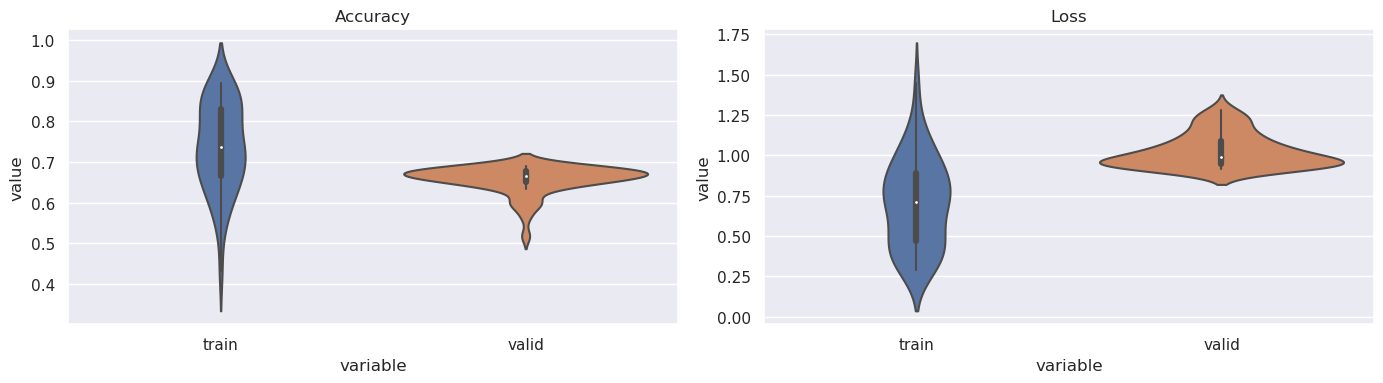

In [32]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

In [23]:
from sklearn.metrics import classification_report

target_names = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise','neutral']
print(classification_report(y_true, y_pred, target_names=target_names))



              precision    recall  f1-score   support

       anger       0.91      0.91      0.91      5086
     disgust       0.91      0.90      0.91      5177
        fear       0.90      0.91      0.91      5120
   happiness       0.91      0.91      0.91      5178
     sadness       0.90      0.90      0.90      5104
    surprise       0.91      0.90      0.90      5099
     neutral       0.91      0.90      0.90      5123

    accuracy                           0.91     35887
   macro avg       0.91      0.91      0.91     35887
weighted avg       0.91      0.91      0.91     35887



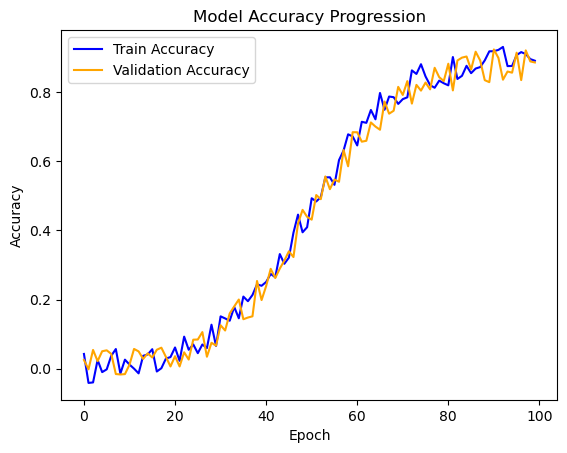

In [55]:
import matplotlib.pyplot as plt

# Plot the accuracy curves
plt.plot(range(num_epochs), train_accuracy, label='Train Accuracy', color='blue')
plt.plot(range(num_epochs), val_accuracy, label='Validation Accuracy', color='orange')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()




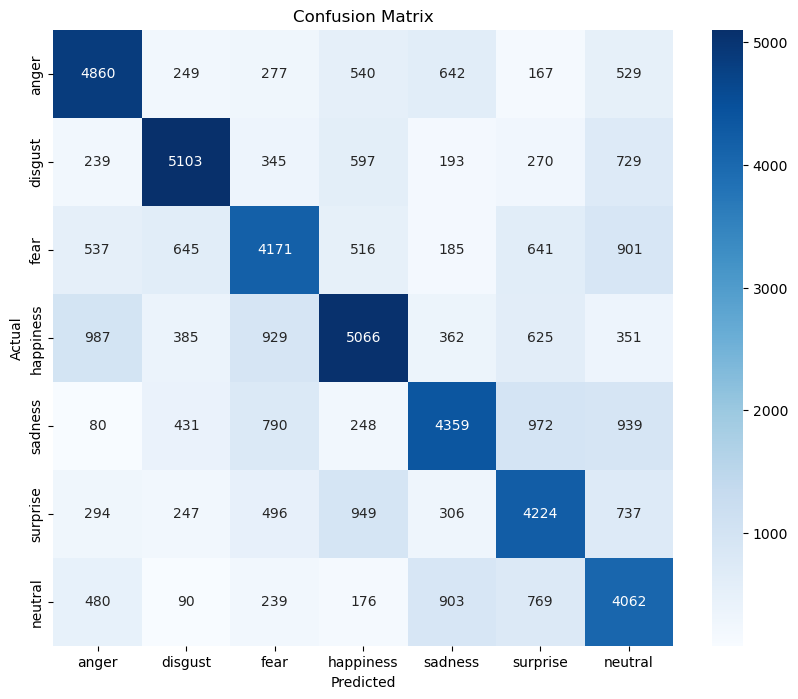

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names=None):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show(
)
# Confusion Matrix
num_classes = 7  # Number of classes in classification
class_names = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise','neutral']
plot_confusion_matrix(confusion_matrix, class_names)



In [34]:
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

1/1 [==============================] - 0s 18ms/step


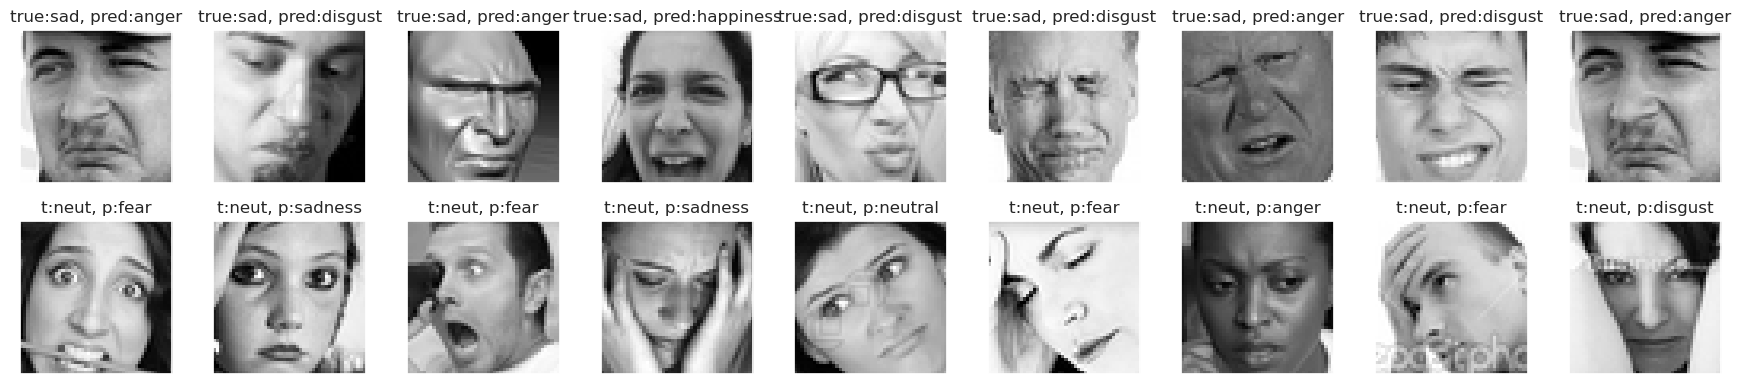

In [35]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)
        
        ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        pyplot.tight_layout()